In [2]:
# ================================
# CELL 1: Kaggle setup + download ECG dataset
# ================================
!pip install -q kaggle

import os
from google.colab import files

print("📁 Upload your kaggle.json file (Kaggle API token).")
uploaded = files.upload()   # choose kaggle.json from your computer

# Auto-detect uploaded filename (in case it's renamed to 'kaggle (1).json', etc.)
filename = list(uploaded.keys())[0]
print("✅ Uploaded:", filename)

# Create Kaggle config directory
os.makedirs('/root/.kaggle', exist_ok=True)

# Save it as /root/.kaggle/kaggle.json
with open('/root/.kaggle/kaggle.json', 'wb') as f:
    f.write(uploaded[filename])

# Correct permissions
os.chmod('/root/.kaggle/kaggle.json', 600)

# Download the ECG Heartbeat Categorization dataset
# Kaggle dataset: https://www.kaggle.com/datasets/shayanfazeli/heartbeat
print("⬇️ Downloading dataset from Kaggle...")
!kaggle datasets download -d shayanfazeli/heartbeat -p /content

print("📦 Unzipping...")
!unzip -o /content/heartbeat.zip -d /content

print("📂 Files in /content:")
!ls -l /content


📁 Upload your kaggle.json file (Kaggle API token).


Saving kaggle.json to kaggle.json
✅ Uploaded: kaggle.json
⬇️ Downloading dataset from Kaggle...
Dataset URL: https://www.kaggle.com/datasets/shayanfazeli/heartbeat
License(s): unknown
  0% 0.00/98.8M [00:00<?, ?B/s]
100% 98.8M/98.8M [00:00<00:00, 1.72GB/s]
📦 Unzipping...
Archive:  /content/heartbeat.zip
  inflating: /content/mitbih_test.csv  
  inflating: /content/mitbih_train.csv  
  inflating: /content/ptbdb_abnormal.csv  
  inflating: /content/ptbdb_normal.csv  
📂 Files in /content:
total 670364
-rw-r--r-- 1 root root 103633768 Oct  1  2019 heartbeat.zip
-rw-r--r-- 1 root root        72 Nov 29 10:16 kaggle.json
-rw-r--r-- 1 root root 102892400 Oct  1  2019 mitbih_test.csv
-rw-r--r-- 1 root root 411503800 Oct  1  2019 mitbih_train.csv
-rw-r--r-- 1 root root  49378200 Oct  1  2019 ptbdb_abnormal.csv
-rw-r--r-- 1 root root  19016200 Oct  1  2019 ptbdb_normal.csv
drwxr-xr-x 1 root root      4096 Nov 20 14:30 sample_data


In [5]:
# ================================
# 🚀 CELL 2 — Full Optimization Training
# ================================

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, Dropout, Flatten, BatchNormalization, Add
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
import os, json

print("TensorFlow:", tf.__version__)

# ---------- 1. Load Data ----------
train_df = pd.read_csv("/content/mitbih_train.csv", header=None)
test_df  = pd.read_csv("/content/mitbih_test.csv", header=None)

X = train_df.iloc[:, :-1].values
y = train_df.iloc[:, -1].astype(int).values

# ---------- 2. Normalize ----------
X_min, X_max = X.min(), X.max()
X = (X - X_min) / (X_max - X_min + 1e-8)
X = X.reshape((X.shape[0], 187, 1))
y_cat = to_categorical(y, num_classes=5)

# ----------
# Train-Val Split
# ----------
X_train, X_val, y_train, y_val = train_test_split(
    X, y_cat, test_size=0.2, stratify=y, random_state=42
)

print("Train:", X_train.shape, "| Val:", X_val.shape)

# ---------- 3. Data Augmentation (ECG-specific) ----------
def augment(batch):
    batch = batch + 0.01 * np.random.randn(*batch.shape)
    shift = np.random.randint(-3, 3)
    batch = np.roll(batch, shift, axis=1)
    return batch

def train_gen():
    while True:
        idx = np.random.randint(0, X_train.shape[0], 256)
        x_batch = X_train[idx]
        y_batch = y_train[idx]
        yield augment(x_batch), y_batch

# ---------- 4. Focal Loss ----------
def focal_loss(gamma=2., alpha=.25):
    def loss(y_true, y_pred):
        eps = 1e-8
        y_pred = tf.clip_by_value(y_pred, eps, 1-eps)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.math.pow((1-y_pred), gamma)
        return tf.reduce_mean(weight * cross_entropy)
    return loss

# ---------- 5. Residual CNN Architecture ----------
def res_block(x, filters, kernel):
    shortcut = x

    # Main path
    x = Conv1D(filters, kernel, padding="same")(x)
    x = BatchNormalization()(x)
    x = tf.keras.activations.relu(x)

    x = Conv1D(filters, kernel, padding="same")(x)
    x = BatchNormalization()(x)

    # 🔧 Project shortcut if channel dimension does not match
    if shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, padding="same")(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Residual add
    x = Add()([shortcut, x])
    x = tf.keras.activations.relu(x)
    x = MaxPooling1D(2)(x)
    return x


inputs = Input(shape=(187,1))
x = Conv1D(32, 7, padding="same", activation="relu")(inputs)
x = BatchNormalization()(x)

x = res_block(x, 64, 5)
x = res_block(x, 128, 3)

x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
outputs = Dense(5, activation="softmax")(x)

model = Model(inputs, outputs)
model.compile(optimizer="adam", loss=focal_loss(), metrics=["accuracy"])
model.summary()

# ---------- 6. Callbacks ----------
checkpoint = "/content/best_model.keras"
callbacks = [
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
    ModelCheckpoint(checkpoint, monitor="val_accuracy", save_best_only=True, verbose=1)
]

# ---------- 7. Train Model ----------
history = model.fit(
    train_gen(),
    steps_per_epoch=300,   # Train on augmented batches
    validation_data=(X_val, y_val),
    epochs=50,
    verbose=1,
    callbacks=callbacks
)

# ---------- 8. Load Best Checkpoint ----------
best_model = tf.keras.models.load_model(checkpoint, compile=False)
best_model.compile(optimizer="adam", loss=focal_loss(), metrics=["accuracy"])

# ---------- 9. Evaluate on Test Set ----------
X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].astype(int).values
X_test = (X_test - X_min) / (X_max - X_min + 1e-8)
X_test = X_test.reshape((X_test.shape[0], 187, 1))
y_test_cat = to_categorical(y_test, 5)

loss, acc = best_model.evaluate(X_test, y_test_cat, verbose=0)
print("\n🎯 Final Test Accuracy: {:.2f}%".format(acc * 100))

# ---------- 10. Save Final Best Model & Params ----------
best_model.save("ecg_cnn_model.keras")
np.savez("preprocess_params.npz", X_min=X_min, X_max=X_max)

with open("class_maps.json", "w") as f:
    json.dump({0:'N',1:'S',2:'V',3:'F',4:'Q'}, f)

print("\n💾 Model Saved: ecg_cnn_model.keras + preprocess_params.npz + class_maps.json")
print("🏁 Training Complete — Next: Confusion Matrix in Cell 3")


TensorFlow: 2.19.0
Train: (70043, 187, 1) | Val: (17511, 187, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 187, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 187, 32)   │        256 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 187, 32)   │        128 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 187, 64)   │     10,304 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 187, 64)   │        256 │ conv1d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 187, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 187, 64)   │      2,112 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 187, 64)   │     20,544 │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 187, 64)   │        256 │ conv1d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 187, 64)   │        256 │ conv1d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 187, 64)   │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 187, 64)   │          0 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 93, 64)    │          0 │ re_lu_3[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 93, 128)   │     24,704 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 93, 128)   │        512 │ conv1d_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 93, 128)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 93, 128)   │      8,320 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 93, 128)   │     49,280 │ re_lu_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 93, 128)   │        512 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 93, 128)   │        512 │ conv1d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 872,389 (3.33 MB)

 Trainable params: 871,173 (3.32 MB)

 Non-trainable params: 1,216 (4.75 KB)

Epoch 1/50
298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8334 - loss: 0.0512
Epoch 1: val_accuracy improved from -inf to 0.29102, saving model to /content/best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - accuracy: 0.8340 - loss: 0.0509 - val_accuracy: 0.2910 - val_loss: 0.0302 - learning_rate: 0.0010
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9543 - loss: 0.0034
Epoch 2: val_accuracy improved from 0.29102 to 0.75450, saving model to /content/best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.9543 - loss: 0.0034 - val_accuracy: 0.7545 - val_loss: 0.0107 - learning_rate: 0.0010
Epoch 3/50
298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9617 - loss: 0.0028
Epoch 3: val_accuracy improved from 0.75450 to 0.97316, saving model to /content/best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.9618 - loss: 0.0028 - val_accuracy: 0.9732 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 4/50
298/300 ━━

In [ ]:
import os

print("Files in /content:")
print(os.listdir("/content"))

print("\nCheckpoint exists?",
      os.path.exists("/content/ecg_cnn_checkpoint.keras"))


Files in /content:
['.config', 'sample_data']

Checkpoint exists? False


In [ ]:
# OPTIONAL: resume training from checkpoint in the SAME session
import os

from tensorflow.keras.models import load_model

checkpoint_path = "/content/ecg_cnn_checkpoint.keras"

if os.path.exists(checkpoint_path):
    print("Reloading best checkpoint and continuing training...")
    model = load_model(checkpoint_path)

    # Continue training for a few more epochs if you want
    history2 = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=128,
        class_weight=class_weights,
        callbacks=callbacks,   # you can reuse the same callbacks
        verbose=1
    )

    # Save again
    model.save("ecg_cnn_model.keras")
else:
    print("No checkpoint found, nothing to resume.")


Reloading best checkpoint and continuing training...
Epoch 1/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8248 - loss: 0.3531
Epoch 1: val_loss did not improve from 0.49121
548/548 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.8248 - loss: 0.3531 - val_accuracy: 0.8253 - val_loss: 0.5013 - learning_rate: 9.0000e-05
Epoch 2/10
539/548 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8266 - loss: 0.3451
Epoch 2: val_loss did not improve from 0.49121
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8266 - loss: 0.3452 - val_accuracy: 0.8134 - val_loss: 0.5551 - learning_rate: 9.0000e-05
Epoch 3/10
541/548 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8243 - loss: 0.3639
Epoch 3: val_loss did not improve from 0.49121
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8244 - loss: 0.3637 - val_accuracy: 0.8271 - val_loss: 0.4978 - learning_rate: 9.0000e-05
Epoch 4/10
546/548 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8278 - loss: 0.3567
Epoch 4: val_loss did no

In [8]:
# ================================
# CELL 3: Helper functions for prediction and diagnosis
# ================================
import numpy as np
import pandas as pd

# Make sure you have already run:
# - Cell 1 (download data)
# - Cell 2 (train model and define X_min, X_max, idx_to_class, class_to_name, model)

def predict_single_beat(signal_1d):
    """
    Predict class for a single ECG beat (1D array of length 187).

    Parameters
    ----------
    signal_1d : array-like
        1D array/list of 187 ECG sample values.

    Returns
    -------
    cls_idx : int
        Predicted class index (0–4)
    cls_code : str
        Class code ('N', 'S', 'V', 'F', 'Q')
    cls_name : str
        Human-readable name (Normal beat, Ventricular ectopic beat, etc.)
    probs : np.ndarray
        Probability distribution over all classes (length = num_classes)
    """
    signal_1d = np.array(signal_1d, dtype=float)
    if signal_1d.ndim != 1 or signal_1d.shape[0] != 187:
        raise ValueError("Input must be a 1D array of length 187")

    # Normalize using training min/max
    signal_1d = (signal_1d - X_min) / (X_max - X_min + 1e-8)

    x = signal_1d.reshape(1, -1, 1)
    probs = model.predict(x)
    cls_idx = int(np.argmax(probs, axis=1)[0])
    cls_code = idx_to_class.get(cls_idx, "?")
    cls_name = class_to_name.get(cls_code, "Unknown")
    return cls_idx, cls_code, cls_name, probs[0]


def predict_csv_file(csv_path, has_label=True):
    """
    Predict classes for all beats in a CSV file.

    Parameters
    ----------
    csv_path : str
        Path to CSV file.
        - If has_label=True: assumes last column is label, first 187 are samples.
        - If has_label=False: assumes all columns are samples.
    has_label : bool
        Whether the last column is a label (like Kaggle format).

    Returns
    -------
    preds : np.ndarray
        Array of predicted class indices (0–4) for each beat.
    """
    # Try UTF-8 normally; fall back to latin1 if weird encoding
    try:
        df = pd.read_csv(csv_path, header=None)
    except UnicodeDecodeError:
        df = pd.read_csv(csv_path, header=None, encoding="latin1")

    # Auto-fix if has_label=True but there are not 188 columns
    if has_label and df.shape[1] == 188:
        X_new = df.iloc[:, :-1].values   # 187 features
    else:
        X_new = df.values                # treat all columns as features

    # Normalize using train stats
    X_new = (X_new - X_min) / (X_max - X_min + 1e-8)

    # Reshape for CNN
    X_new = X_new.reshape((X_new.shape[0], X_new.shape[1], 1))

    # Predict
    probs = model.predict(X_new)
    preds = np.argmax(probs, axis=1)

    print(f"Total beats in file: {len(preds)}")
    for i, cls_idx in enumerate(preds[:20]):  # show only first 20
        cls_code = idx_to_class.get(cls_idx, "?")
        cls_name = class_to_name.get(cls_code, "Unknown")
        print(f"Beat {i}: class {cls_idx} ({cls_code}) -> {cls_name}")

    return preds


def diagnosis_report(preds):
    """
    Print a summary of beats by arrhythmia type.

    Parameters
    ----------
    preds : array-like
        Predicted class indices (0–4) for each beat.
    """
    preds = np.array(preds)
    unique, counts = np.unique(preds, return_counts=True)
    total = len(preds)

    print("\n==================")
    print("DIAGNOSIS REPORT")
    print("==================")

    for u, c in zip(unique, counts):
        code = idx_to_class.get(int(u), "?")
        name = class_to_name.get(code, "Unknown")
        print(f"{name}: {c} beats ({(c/total)*100:.2f}%)")

    # Simple final result
    if np.sum(preds != 0) == 0:
        print("\nFinal result: 🟢 Normal ECG — No arrhythmia detected")
    else:
        print("\nFinal result: 🔴 Arrhythmia detected — Consult a cardiologist")


685/685 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step

🎯 Overall Test Accuracy: 98.00%

📌 Classification Report:
              precision    recall  f1-score   support

           N       0.98      0.99      0.99     18118
           S       0.93      0.68      0.78       556
           V       0.93      0.95      0.94      1448
           F       0.88      0.64      0.74       162
           Q       0.99      0.98      0.99      1608

    accuracy                           0.98     21892
   macro avg       0.94      0.85      0.89     21892
weighted avg       0.98      0.98      0.98     21892



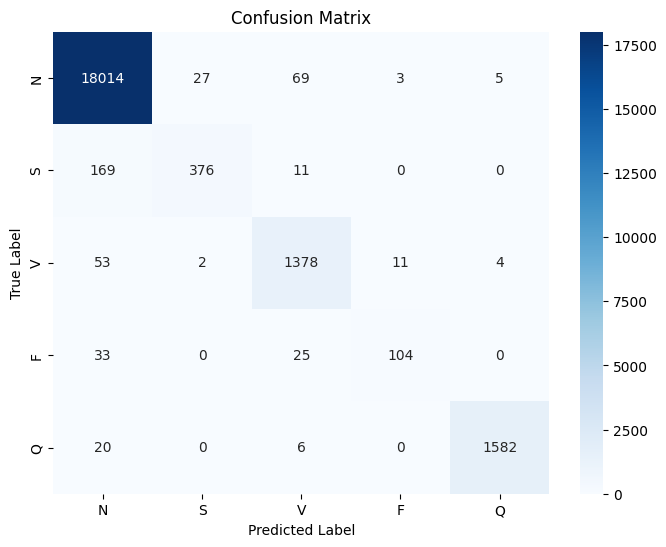

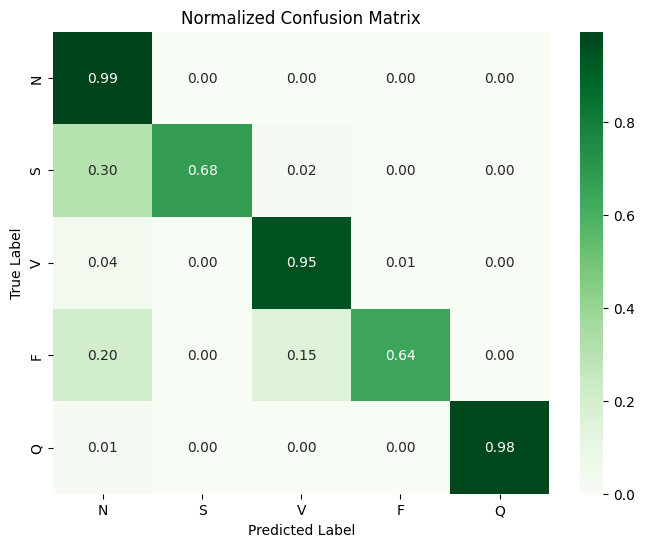


✔ All evaluation metrics generated successfully!


In [9]:
# =====================
# CELL  — Evaluation & Metrics
# =====================

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Re-run test preprocessing to ensure matching scale
X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].astype(int).values

X_test = (X_test - X_min) / (X_max - X_min + 1e-8)
X_test = X_test.reshape((X_test.shape[0], 187, 1))

# Predictions
y_prob = best_model.predict(X_test)
y_pred = np.argmax(y_prob, axis=1)

# Labels mapping
label_names = ['N', 'S', 'V', 'F', 'Q']

# Overall accuracy
acc = accuracy_score(y_test, y_pred) * 100
print(f"\n🎯 Overall Test Accuracy: {acc:.2f}%")

# Classification Report
print("\n📌 Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# =================
# Confusion Matrix Plot
# =================
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_names,
            yticklabels=label_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# =================
# Normalized Confusion Matrix
# =================
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8,6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Greens",
            xticklabels=label_names,
            yticklabels=label_names)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("\n✔ All evaluation metrics generated successfully!")


In [13]:
print("🔄 Restoring saved model and preprocessing params...")

best_model = tf.keras.models.load_model("ecg_cnn_model.keras", compile=False)
params = np.load("preprocess_params.npz")
X_min = params["X_min"]
X_max = params["X_max"]

import json
with open("class_maps.json", "r") as f:
    class_map = json.load(f)
idx_to_class = {int(k): v for k, v in class_map.items()}
class_to_name = {
    'N': "Normal beat",
    'S': "Supraventricular ectopic beat",
    'V': "Ventricular ectopic beat",
    'F': "Fusion beat",
    'Q': "Unknown / paced beat"
}

print("✔ Model + parameters successfully loaded!")


🔄 Restoring saved model and preprocessing params...
✔ Model + parameters successfully loaded!


📁 Upload an ECG CSV file (187 columns, with or without label)...


Saving mitbih_test.csv to mitbih_test (2).csv
✅ File received: mitbih_test (2).csv

Detected format: Labeled ✔ (187 + label)
685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

Total beats in file: 21892
Beat 0: class 0 (N) -> Normal beat
Beat 1: class 0 (N) -> Normal beat
Beat 2: class 0 (N) -> Normal beat
Beat 3: class 0 (N) -> Normal beat
Beat 4: class 0 (N) -> Normal beat
Beat 5: class 0 (N) -> Normal beat
Beat 6: class 0 (N) -> Normal beat
Beat 7: class 0 (N) -> Normal beat
Beat 8: class 0 (N) -> Normal beat
Beat 9: class 0 (N) -> Normal beat
Beat 10: class 0 (N) -> Normal beat
Beat 11: class 0 (N) -> Normal beat
Beat 12: class 0 (N) -> Normal beat
Beat 13: class 0 (N) -> Normal beat
Beat 14: class 0 (N) -> Normal beat
Beat 15: class 2 (V) -> Ventricular ectopic beat
Beat 16: class 0 (N) -> Normal beat
Beat 17: class 0 (N) -> Normal beat
Beat 18: class 0 (N) -> Normal beat
Beat 19: class 0 (N) -> Normal beat

DIAGNOSIS REPORT
Normal beat: 18289 beats (83.54%)
Supraventricular ectopic beat: 

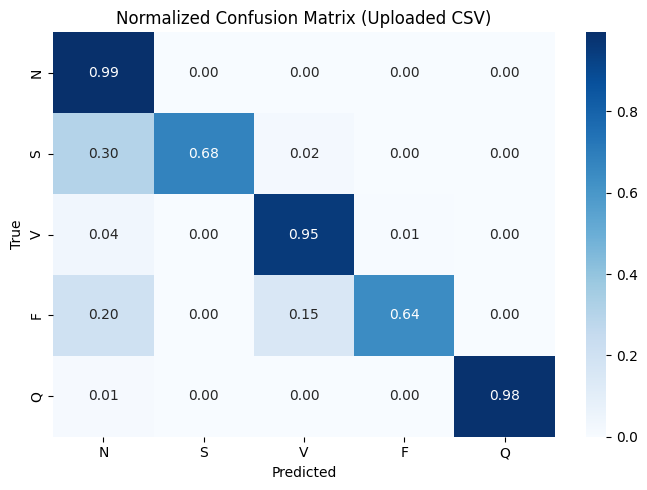

In [14]:
# ================================
# CELL 4: Upload ECG CSV, diagnose + (if labeled) compute metrics
# ================================
from google.colab import files
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Use best_model if defined, else fallback to model
clf_model = best_model if 'best_model' in globals() else model

print("📁 Upload an ECG CSV file (187 columns, with or without label)...")
uploaded = files.upload()
csv_name = list(uploaded.keys())[0]
csv_path = f"/content/{csv_name}"
print("✅ File received:", csv_name)

# Robust CSV reading
try:
    df = pd.read_csv(csv_path, header=None)
except UnicodeDecodeError:
    df = pd.read_csv(csv_path, header=None, encoding="latin1")

# Auto-detect labeled/unlabeled
has_label = (df.shape[1] == 188)
print("\nDetected format:", "Labeled ✔ (187 + label)" if has_label else "Unlabeled ✔ (only samples)")

# ----- Prepare data -----
if has_label:
    X_new = df.iloc[:, :-1].values      # 187 features
    y_true = df.iloc[:, -1].astype(int).values
else:
    X_new = df.values                   # all columns are features
    y_true = None

# Normalize using training stats
X_new = (X_new - X_min) / (X_max - X_min + 1e-8)
X_new = X_new.reshape((X_new.shape[0], X_new.shape[1], 1))

# Predict
probs = clf_model.predict(X_new)
preds = np.argmax(probs, axis=1)

# Show first few beats like before
print(f"\nTotal beats in file: {len(preds)}")
for i, cls_idx in enumerate(preds[:20]):
    cls_code = idx_to_class.get(int(cls_idx), "?")
    cls_name = class_to_name.get(cls_code, "Unknown")
    print(f"Beat {i}: class {cls_idx} ({cls_code}) -> {cls_name}")

# Diagnosis summary (your existing function)
diagnosis_report(preds)

# ----- If labels exist, compute metrics -----
if has_label:
    label_names = [class_to_name[idx_to_class[i]] for i in range(5)]

    acc = accuracy_score(y_true, preds) * 100
    print("\n==================")
    print("EVALUATION METRICS (for uploaded file)")
    print("==================")
    print(f"Overall Accuracy: {acc:.2f}%\n")

    print("Classification Report:")
    print(classification_report(y_true, preds, target_names=label_names))

    cm = confusion_matrix(y_true, preds)
    print("Confusion Matrix (raw counts):")
    print(cm)

    # Plot normalized confusion matrix
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(7,5))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=[idx_to_class[i] for i in range(5)],
                yticklabels=[idx_to_class[i] for i in range(5)])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Normalized Confusion Matrix (Uploaded CSV)")
    plt.tight_layout()
    plt.show()
else:
    print("\n(No ground-truth labels in this file, so accuracy/recall cannot be computed.)")


In [15]:
from google.colab import files

files.download("ecg_cnn_model.keras")
files.download("preprocess_params.npz")
files.download("class_maps.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Use the test CSV from the Kaggle dataset itself
test_path  = "/content/mitbih_test.csv"

preds = predict_csv_file(test_path, has_label=True)
diagnosis_report(preds)


685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Total beats in file: 21892
Beat 0: class 0 (N) -> Normal beat
Beat 1: class 2 (V) -> Ventricular ectopic beat
Beat 2: class 0 (N) -> Normal beat
Beat 3: class 0 (N) -> Normal beat
Beat 4: class 0 (N) -> Normal beat
Beat 5: class 0 (N) -> Normal beat
Beat 6: class 0 (N) -> Normal beat
Beat 7: class 0 (N) -> Normal beat
Beat 8: class 0 (N) -> Normal beat
Beat 9: class 1 (S) -> Supraventricular ectopic beat
Beat 10: class 0 (N) -> Normal beat
Beat 11: class 0 (N) -> Normal beat
Beat 12: class 3 (F) -> Fusion beat
Beat 13: class 0 (N) -> Normal beat
Beat 14: class 0 (N) -> Normal beat
Beat 15: class 2 (V) -> Ventricular ectopic beat
Beat 16: class 0 (N) -> Normal beat
Beat 17: class 0 (N) -> Normal beat
Beat 18: class 0 (N) -> Normal beat
Beat 19: class 0 (N) -> Normal beat

DIAGNOSIS REPORT
Normal beat: 14607 beats (66.72%)
Supraventricular ectopic beat: 2283 beats (10.43%)
Ventricular ectopic beat: 1815 beats (8.29%)
Fusion beat: 1470 beats (6.71%

In [17]:
from tensorflow.keras.utils import to_categorical

# Number of classes (important if kernel restart happened)
num_classes = 5

# Load test set again
test_df = pd.read_csv("/content/mitbih_test.csv", header=None)

X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].astype(int).values

# Normalize same as training
X_test = (X_test - X_min) / (X_max - X_min + 1e-8)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# One-hot encode labels
y_test_cat = to_categorical(y_test, num_classes=num_classes)

# Evaluate model performance
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=1)
print(f"\n🎯 Test Accuracy: {test_accuracy * 100:.2f}%")


685/685 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9921 - loss: 5.1975e-04

🎯 Test Accuracy: 98.00%
